In [1]:
from bs4 import BeautifulSoup 
import pandas as pd
# pd.options.display.max_rows = 1000
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
sns.set(style='whitegrid');

In [2]:
# virus stats api
api = 'https://lab.isaaclin.cn/nCoV/api/overall'
# api_backup = https://www.tianqiapi.com/api?version=epidemic&appid=23035354&appsecret=8YvlPNrz
# parameter to get all historical number since 1/24/2020
par = {'latest': '0'}
result = requests.get(api, params=par)
result.status_code

200

In [3]:
data = result.json()

In [4]:
last_update = datetime.fromtimestamp(data['results'][0]['updateTime']//1000).strftime("%Y-%m-%d %H:%M:%S")
last_update

'2020-02-11 22:48:47'

In [5]:
# get key info of report
date = []
confirmedCount = []
suspectedCount = []
curedCount = []
deadCount = []
seriousCount = []
suspectedIncr = []
confirmedIncr = []
curedIncr = []
seriousIncr = []

for i in range(len(data['results'])):
#     print(i)
    date.append(datetime.fromtimestamp(data['results'][i]['updateTime']//1000).strftime("%Y-%m-%d %H:%M:%S"))
    confirmedCount.append(data['results'][i]['confirmedCount'])
    suspectedCount.append(data['results'][i]['suspectedCount'])
    curedCount.append(data['results'][i]['curedCount'])
    deadCount.append(data['results'][i]['deadCount'])
    # this data didn't exist in older daily count
    try:
        seriousCount.append(data['results'][i]['seriousCount'])
        suspectedIncr.append(data['results'][i]['suspectedIncr'])
        confirmedIncr.append(data['results'][i]['confirmedIncr'])
        curedIncr.append(data['results'][i]['curedIncr'])
        seriousIncr.append(data['results'][i]['seriousIncr'])
    except KeyError:
        seriousCount.append(0)
        suspectedIncr.append(0)
        confirmedIncr.append(0)
        curedIncr.append(0)
        seriousIncr.append(0)

In [6]:
# put all info into one df
df_millisecond = pd.DataFrame(list(zip(date, confirmedCount, suspectedCount, curedCount, deadCount, seriousCount, suspectedIncr, confirmedIncr, curedIncr, seriousIncr)),
                 columns=['date', 'confirmedCount', 'suspectedCount', 'curedCount', 'deadCount', 'seriousCount', 'suspectedIncr', 'confirmedIncr', 'curedIncr', 'seriousIncr'])
df_millisecond['date'] = pd.to_datetime(df_millisecond['date'])

In [7]:
df_millisecond.head()

,date,confirmedCount,suspectedCount,curedCount,deadCount,seriousCount,suspectedIncr,confirmedIncr,curedIncr,seriousIncr
0,2020-02-11 22:48:47,44742,16067,4771,1114,8204,3342,2034,773,871
1,2020-02-11 22:30:01,44742,16067,4762,1114,8204,3342,2034,764,871
2,2020-02-11 22:19:38,44742,16067,4744,1114,8204,3342,2034,746,871
3,2020-02-11 22:08:12,44742,16067,4744,1114,8204,3342,2034,746,871
4,2020-02-11 22:05:05,44742,16067,4744,1114,8204,3342,2034,746,871


In [9]:
df_millisecond[df_millisecond['date'] == last_update_time].index.values

array([], dtype=int64)

In [12]:
# create another df show data by day
day_name = df_millisecond['date'].dt.day.unique() 
ix_lastUpdate = []
for day in day_name:
    try:
        last_update_time = df_millisecond[(df_millisecond['date'].dt.day==day)&
                                         # suspecte incr data is not updated on each row
                                          (df_millisecond['suspectedIncr']!=0)]['date'].max()
        ix = df_millisecond[df_millisecond['date'] == last_update_time].index.values[0]
    except IndexError:
        last_update_time = df_millisecond[(df_millisecond['date'].dt.day==day)]['date'].max()
        ix = df_millisecond[df_millisecond['date'] == last_update_time].index.values[0]
    ix_lastUpdate.append(ix)

In [13]:
# reset dataframe format
# number by the end of day
df_day = df_millisecond.iloc[ix_lastUpdate]
df_day['date'] = df_day['date'].dt.date

# reset index as date to facilitate calculation
df_day.index = df_day['date']
# set this to string to facilitate plot 
# df_day['date'] = df_day['date'].astype(str)
df_day.sort_index(inplace=True)
# add death and cure rate
df_day['deathRate'] = round(df_day['deadCount']/df_day['confirmedCount'],4)
df_day['cureRate'] = round(df_day['curedCount']/df_day['confirmedCount'], 4)

/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/jonzhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

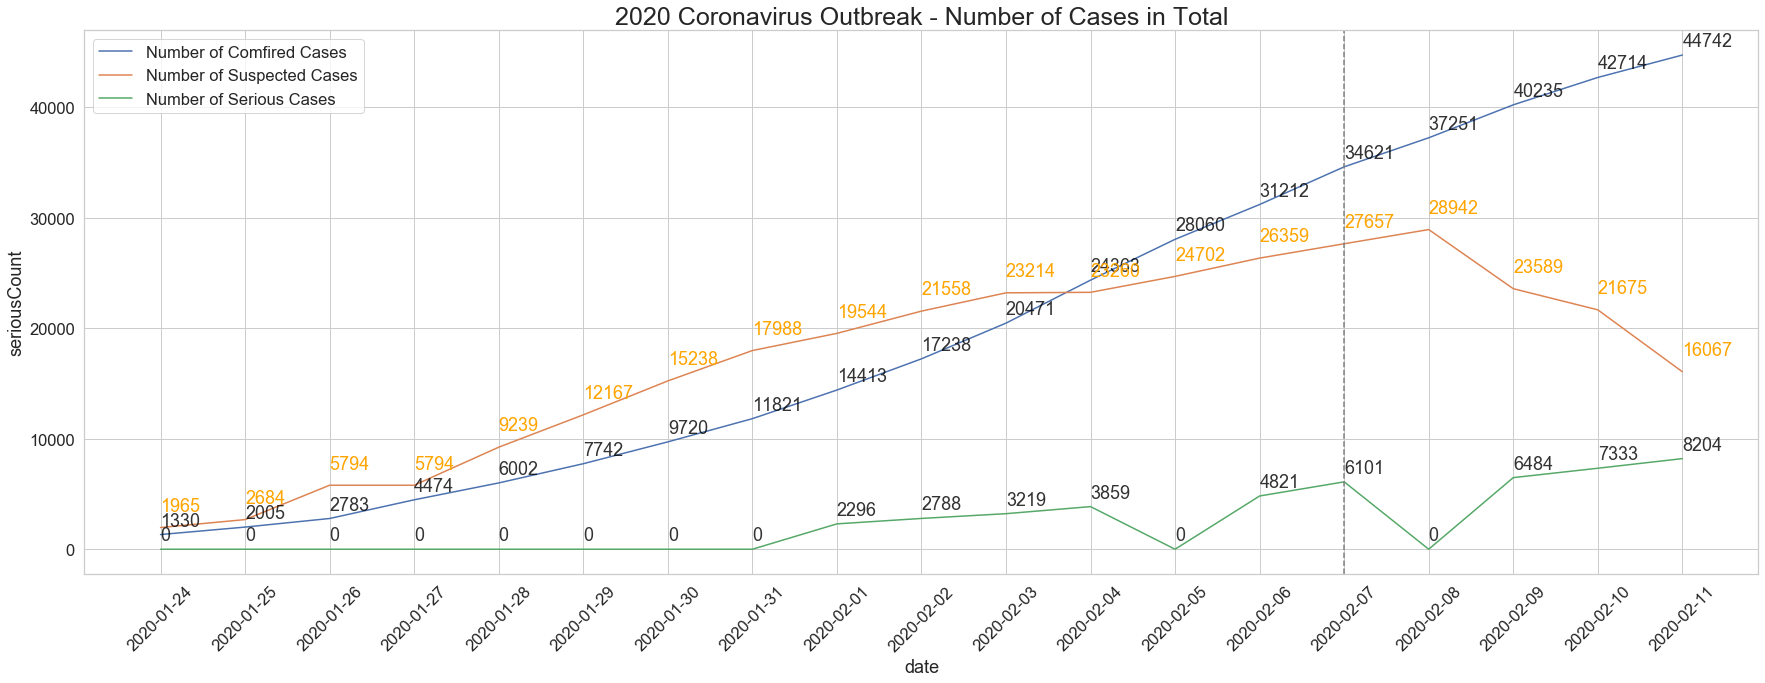

In [14]:
#plot
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['confirmedCount'], ax=ax1, label = 'Number of Comfired Cases').set_title('2020 Coronavirus Outbreak - Number of Cases in Total', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['suspectedCount'], ax=ax1, label = 'Number of Suspected Cases')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['seriousCount'], ax=ax1, label = 'Number of Serious Cases')
# add data label
[ax1.text(p[0], p[1]+800, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['confirmedCount'])]
[ax1.text(p[0], p[1]+1500, p[1], color='orange', alpha=1) for p in zip(ax1.get_xticks(), df_day['suspectedCount'])]
[ax1.text(p[0], p[1]+800, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['seriousCount'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

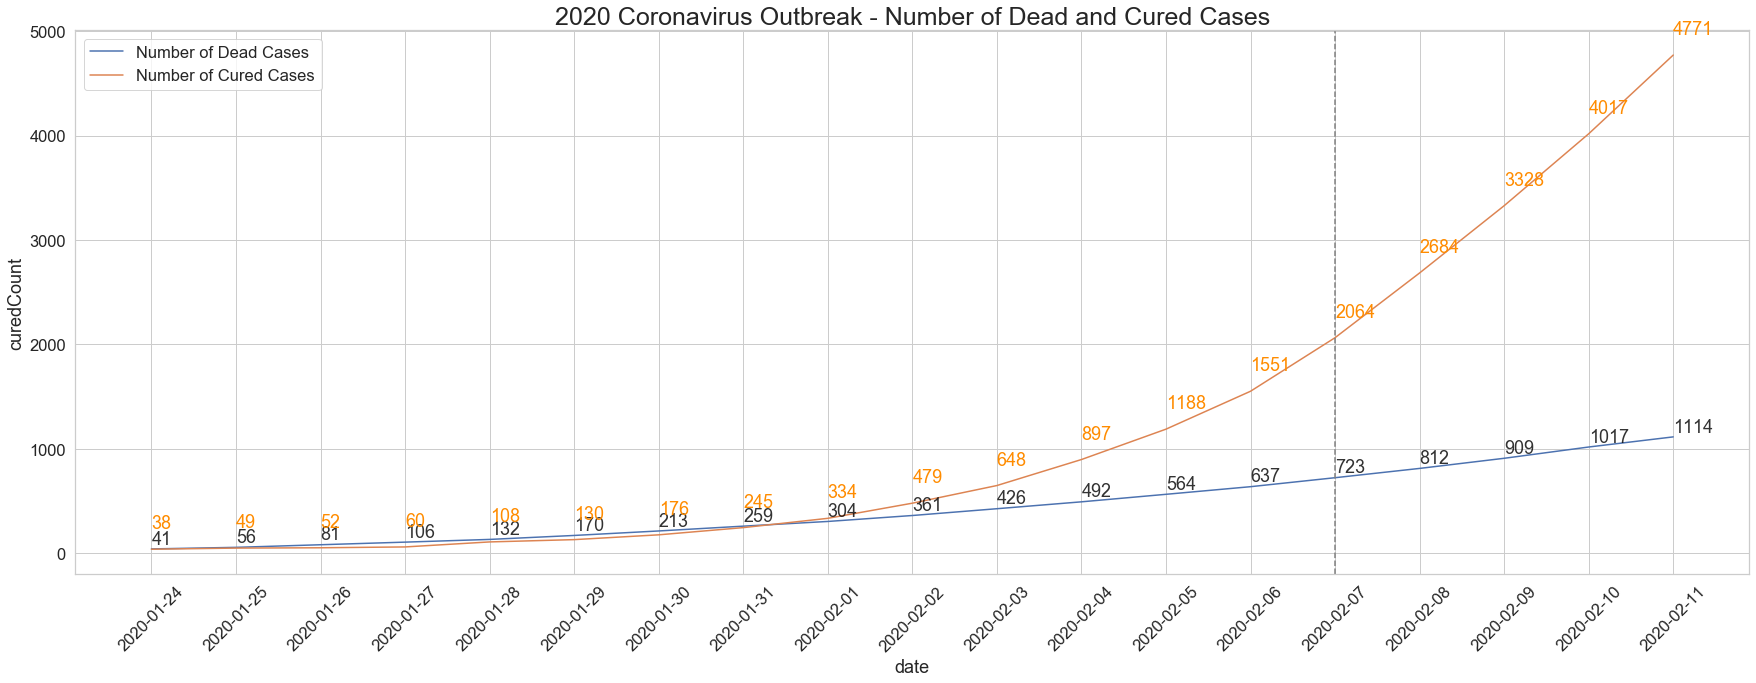

In [15]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['deadCount'], ax=ax1, label = 'Number of Dead Cases').set_title('2020 Coronavirus Outbreak - Number of Dead and Cured Cases', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['curedCount'], ax=ax1, label = 'Number of Cured Cases')
# add data label
[ax1.text(p[0], p[1]+50, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['deadCount'])]
[ax1.text(p[0], p[1]+200, p[1], color='darkorange', alpha=1) for p in zip(ax1.get_xticks(), df_day['curedCount'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

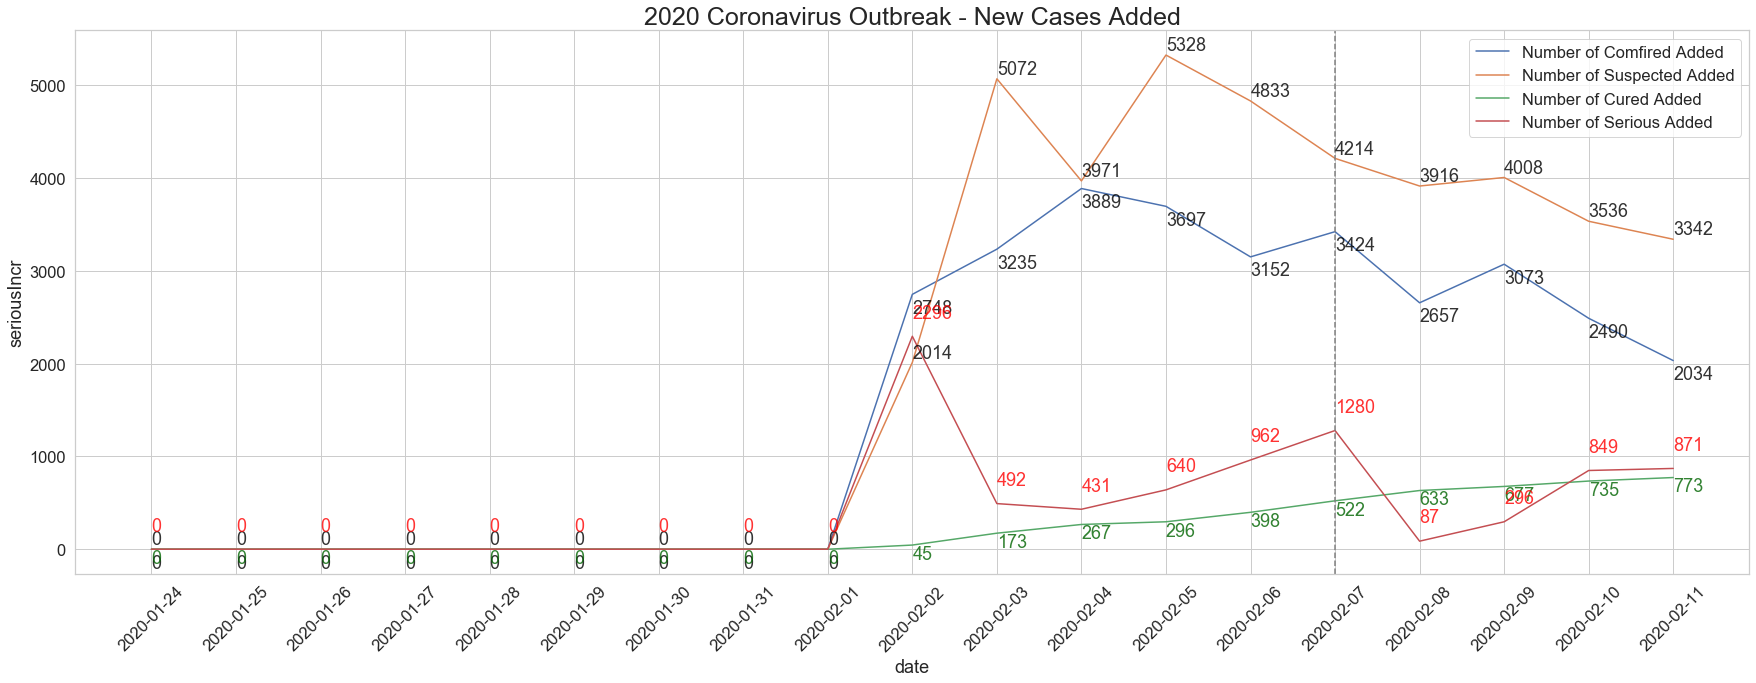

In [16]:
#plot dead cured 
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['confirmedIncr'], ax=ax1, label = 'Number of Comfired Added').set_title('2020 Coronavirus Outbreak - New Cases Added', fontsize=25)
sns.lineplot(x=df_day['date'].astype(str), y=df_day['suspectedIncr'], ax=ax1, label = 'Number of Suspected Added')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['curedIncr'], ax=ax1, label = 'Number of Cured Added')
sns.lineplot(x=df_day['date'].astype(str), y=df_day['seriousIncr'], ax=ax1, label = 'Number of Serious Added')
# add data label
[ax1.text(p[0], p[1]-200, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['confirmedIncr'])]
[ax1.text(p[0], p[1]+50, p[1], color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['suspectedIncr'])]
[ax1.text(p[0], p[1] - 150, p[1], color='darkgreen', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['curedIncr'])];
[ax1.text(p[0], p[1]+200, p[1], color='red', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['seriousIncr'])];
# 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

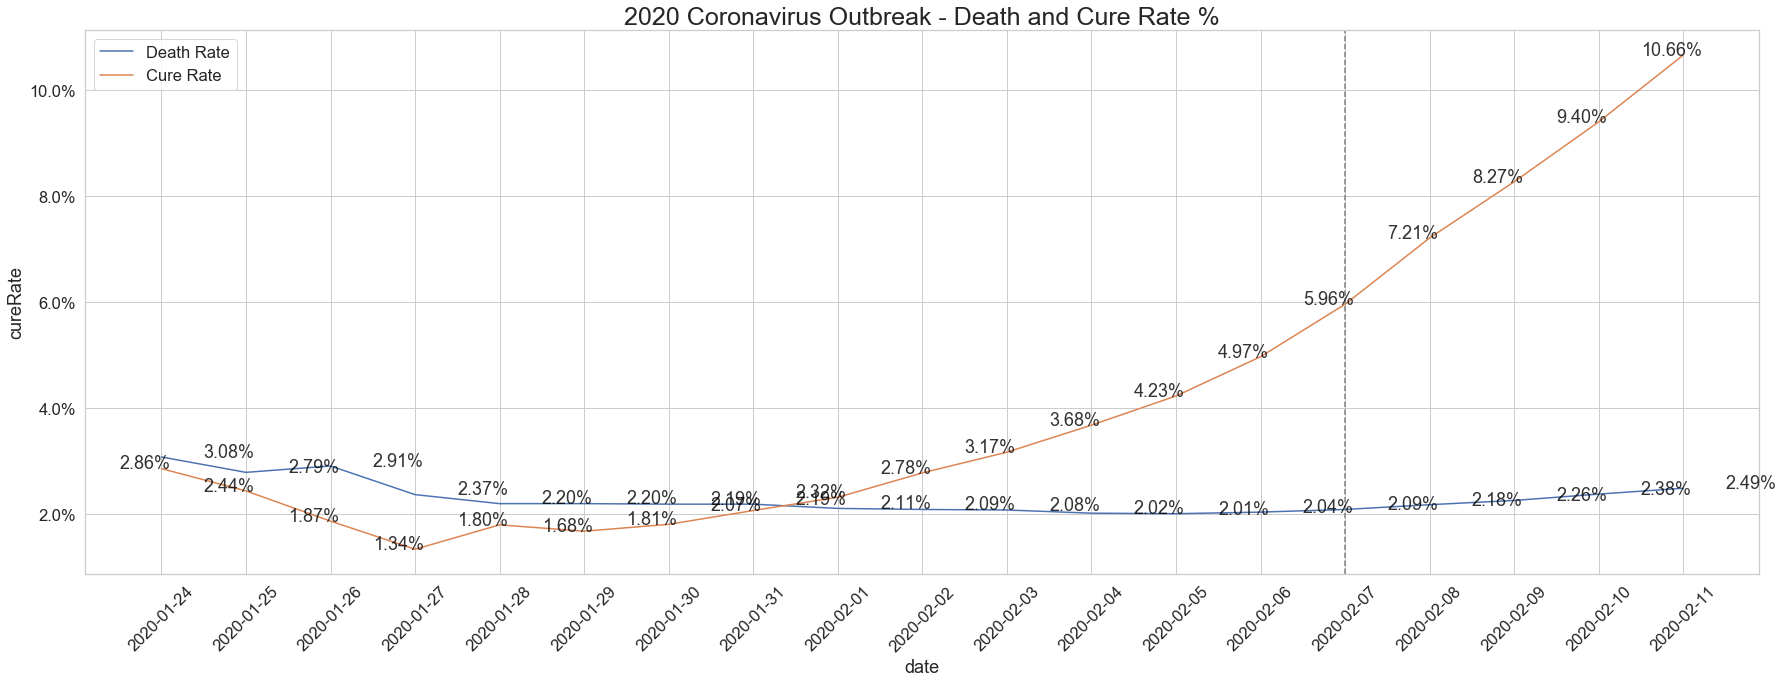

In [19]:
#plot dead cured
sns.set(style='whitegrid', font_scale=1.5)
f, (ax1) = plt.subplots(figsize=(30,10))
# rotate each xaxis tick
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
sns.lineplot(x=df_day['date'].astype(str), y=df_day['deathRate'], ax=ax1, label = 'Death Rate').set_title('2020 Coronavirus Outbreak - Death and Cure Rate %', fontsize=25);
sns.lineplot(x=df_day['date'].astype(str), y=df_day['cureRate'], ax=ax1, label = 'Cure Rate')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# add data label
[ax1.text(p[0]+ 0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['deathRate'])];
[ax1.text(p[0]-0.5, p[1], '{:,.2%}'.format(p[1]), color='black', alpha=0.8) for p in zip(ax1.get_xticks(), df_day['cureRate'])];

# # 14 days lag of outbreak
ax1.axvline(str(df_day['date'][0] + timedelta(days=14)),color='grey', linestyle = '--');

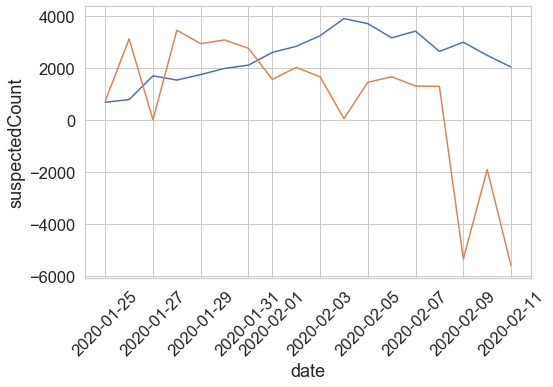

In [31]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.lineplot(x=df_day['date'], y=df_day.diff()['confirmedCount'])
sns.lineplot(x=df_day['date'], y=df_day.diff()['suspectedCount']);